In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')
# import os
# os.chdir('/content/drive/MyDrive/project/OMISTL/MPC')
# os.chdir('/content/drive/MyDrive/Colab Notebooks/OMISTL/MPC')

In [ ]:
# !pip3 install graycode
# !pip3 install treelib
# !pip3 install cvxpy==1.1.20
# !pip3 install mosek==9.3.20

In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
%matplotlib inline

import torch
from torch.autograd import Variable
import numpy as np

import sys
sys.path.append("..")
from solvers.OMISTL import OMISTL
import cvxpy as cp
from utils import *
import pickle, os
from MPC_prob import MPC

from tqdm import tqdm
from para import paraset
from test_results import test_strategy
from test_results import load_result

import seaborn as sns
import matplotlib.pyplot as plt
import math
import seaborn as sns

os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'#不设这个解不出#

C:\Users\msi\anaconda3\envs\coco\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\msi\anaconda3\envs\coco\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
C:\Users\msi\anaconda3\envs\coco\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  stacklevel=1)


In [11]:
N= 12
n_obs = 6
paraset(N=N, n_obs=n_obs,Qs=1,Rs=0,num_probs=20000,obs_default=False)

In [12]:
#pass the value from config to dict and para
relative_path = os.getcwd()
dataset_name = 'MPC_horizon_{}_obs_{}'.format(N,n_obs)
# dataset_name = 'NSTL_{}_horizon_{}'.format(Qs, N)
config_fn = os.path.join(relative_path, 'config', dataset_name+'.p')

# config = [dataset_name, [prob_params] ,sampled_params]
outfile = open(config_fn,"rb")
config=pickle.load(outfile)
outfile.close()

train_fn = 'train_horizon_{}.p'.format(N)
train_fn = os.path.join(relative_path, 'data', dataset_name, train_fn)
test_fn = 'test_horizon_{}.p'.format(N)
test_fn = os.path.join(relative_path, 'data', dataset_name, test_fn)

all_params = ['N', 'Ak', 'Bk', 'Q', 'R', 'n_obs', \
            'posmin', 'posmax', 'velmin', 'velmax', \
            'umin', 'umax']

param_dict={}
i=0
len_para = len(all_params)
for param in all_params:
    param_dict[param]= config[1][i]
    i+=1
    if i == len_para:
        break

N = param_dict['N']
Ak = param_dict['Ak']
Bk = param_dict['Bk']
Q = param_dict['Q']
R = param_dict['R']
n_obs = param_dict['n_obs']
umin = param_dict['umin']
umax = param_dict['umax']
sampled_params = config[2]
n_obs = config[3]
num_probs = config[4]
border_size = config[5]
box_buffer = config[6]
min_box_size = config[7]
max_box_size = config[8]
posmin = config[9]
posmax = config[10]
velmin = config[11]
velmax = config[12]
n = config[13]
m= config[14]

obs_fix = config[15]
xg_fix = config[16]
if obs_fix:
    obstacles = config[-1]

config_fn = os.path.join(relative_path, 'config', dataset_name+'.p')#

prob = MPC(config=config_fn)
#create numpy containers for data: (params, x, u, y, J*, solve_time)
params = {}
if 'x0' in sampled_params:
    params['x0'] = np.zeros((num_probs,2*n))
if 'xg' in sampled_params:
    params['xg'] = np.zeros((num_probs,2*n))
if 'obstacles' in sampled_params:
    params['obstacles'] = np.zeros((num_probs, 4, n_obs))

X = np.zeros((num_probs, 2*n, N));
U = np.zeros((num_probs, m, N-1))
Y = np.zeros((num_probs, 4*n_obs, N-1)).astype(int)
Z = np.zeros((num_probs, 2*n_obs, N-1)).astype(int)

costs = np.zeros(num_probs)
solve_times = np.zeros(num_probs)

prob.sampled_params = ['x0', 'xg', 'obstacles']

#solving MICP
ii_toggle = 0
obs_new_ct = 5
ii=0
obstacles = config[-1]

if obs_fix:
    for ii in tqdm(range(num_probs)):
        x0 = findIC(obstacles, posmin, posmax, velmin, velmax)
        params['obstacles'][ii,:] = np.reshape(np.concatenate(obstacles, axis=0), (n_obs,4)).T
        p_dict = {}
        params['x0'][ii,:] = x0
        xg= findIC(obstacles, posmin, posmax, velmin, velmax)
        params['xg'][ii,:] = xg

        p_dict['x0'] = params['x0'][ii,:]
        p_dict['xg'] = params['xg'][ii,:]
        p_dict['obstacles'] = params['obstacles'][ii,:]

        prob_success = False
        try:
            # with time_limit(20):
            prob_success, cost, solve_time, optvals = prob.solve_stl(p_dict, solver=cp.GUROBI)
        except (KeyboardInterrupt, SystemExit):
            raise
        except:
            print('solver failed at '.format(ii))

        if prob_success:
            costs[ii] = cost; solve_times[ii] = solve_time
            X[ii,:,:], U[ii,:,:], Y[ii,:,:], Z[ii,:,:] = optvals
            ii += 1
else:
    print('choose to fix obstalce')

## shuffle the data because of the spatial orders
num_train = int(num_probs*0.9)
arr = np.arange(num_probs)
np.random.shuffle(arr)

if 'x0' in sampled_params:
    params['x0'] = params['x0'][arr]
if 'xg' in sampled_params:
    params['xg'] = params['xg'][arr]
if 'obstacles' in sampled_params:
    params['obstacles'] = params['obstacles'][arr]

costs = costs[arr]
solve_times = solve_times[arr]


X = X[arr]
U = U[arr]
Y = Y[arr]
Z = Z[arr]

train_params = {}; test_params = {}
if 'x0' in sampled_params:
    train_params['x0'] = params['x0'][:num_train,:]
    test_params['x0'] = params['x0'][num_train:,:]
if 'obstacles' in sampled_params:
    train_params['obstacles'] = params['obstacles'][:num_train,:]
    test_params['obstacles'] = params['obstacles'][num_train:,:]
if 'xg' in sampled_params:
    train_params['xg'] = params['xg'][:num_train,:]
    test_params['xg'] = params['xg'][num_train:,:]

train_data = [train_params]
train_data += [X[:num_train,:,:], U[:num_train,:,:], Y[:num_train,:,:],Z[:num_train,:,:]]
train_data += [costs[:num_train], solve_times[:num_train]]

test_data = [test_params]
test_data += [X[num_train:,:,:], U[num_train:,:,:], Y[num_train:,:,:], Z[:num_train,:,:]]
test_data += [costs[num_train:], solve_times[num_train:]]

train_file = open(train_fn,'wb')
pickle.dump(train_data,train_file); train_file.close()

test_file = open(test_fn, 'wb')
pickle.dump(test_data,test_file); test_file.close()

  0%|          | 0/20000 [00:00<?, ?it/s]

Academic license - for non-commercial use only - expires 2022-12-22
Using license file C:\Users\msi\gurobi.lic


  0%|          | 9/20000 [00:04<1:39:14,  3.36it/s]C:\Users\msi\anaconda3\envs\coco\lib\site-packages\cvxpy\problems\problem.py:1306: UserWarning: 
    The problem is either infeasible or unbounded, but the solver
    cannot tell which. Disable any solver-specific presolve methods
    and re-solve to determine the precise problem status.

    For GUROBI and CPLEX you can automatically perform this re-solve
    with the keyword argument prob.solve(reoptimize=True, ...).
    
  warnings.warn(INF_OR_UNB_MESSAGE)
100%|██████████| 20000/20000 [1:31:46<00:00,  3.63it/s]  


In [3]:
relative_path = os.getcwd()
dataset_name = 'MPC_horizon_{}_obs_{}'.format(N,n_obs)
# dataset_name = 'NSTL_{}_horizon_{}'.format(Qs, N)
config_fn = os.path.join(relative_path, 'config', dataset_name+'.p')
prob = MPC(config=config_fn) #use default config, pass different config file oth.

relative_path = os.getcwd()
dataset_fn = relative_path + '/data/' + dataset_name

##load train data
train_file = open(dataset_fn+'/train_horizon_{}.p'.format(N),'rb')
# train_file = open(dataset_fn+'/train.p','rb')
train_data = pickle.load(train_file)
p_train, x_train, u_train, y_train, z_train, cost_train, times_train = train_data
train_file.close()

x_train = train_data[1] #X sequence
y_train = train_data[3] #Y sequence

##load test data
test_file = open(dataset_fn+'/test_horizon_{}.p'.format(N),'rb')
# test_file = open(dataset_fn+'/test.p','rb')
# p_test, x_test, u_test, y_test, c_test, times_test = pickle.load(test_file)
test_data = pickle.load(test_file)
p_test, x_test, u_test, y_test,z_test, cost_test,times_test = test_data
test_file.close()

In [50]:
system = 'MPC'
prob_features = ['x0','xg','obstacles']
# prob_features = ['x0','obstacles_map']
MPC_obj = OMISTL(system, prob, prob_features)

# dimensions of features are 4(x0)+4(xg)+4*number_obstacles+n_obs(onehot_index)

n_features = 2*prob.n*(len(prob_features)-1)+n_obs*4+n_obs
MPC_obj.construct_strategies(n_features, train_data)
print('nubmber of strategies:'+ str(MPC_obj.n_strategies))
print('n_obs: '+ str(n_obs))
print('N: '+ str(N))
MPC_obj.n_evals
MPC_obj.setup_network()
fn_saved = 'D:\Curious\OMISTL\\models\\MPC_horizon_{}_obs_{}.pt'.format(N,n_obs)
MPC_obj.load_network(fn_saved)

nubmber of strategies:2202
n_obs: 5
N: 10
Loading presaved classifier model from D:\Curious\OMISTL\models\MPC_horizon_10_obs_5.pt


In [8]:
# MPC_obj.training_params['TRAINING_ITERATIONS'] = 500
# MPC_obj.train(train_data=train_data, verbose=True)
# MPC_obj.model

loss:   4.980214595794678,   acc:  0.3125
loss:   3.3978090286254883,   acc:  0.375
Done with epoch 0 in 13.799950361251831s
loss:   3.5012383460998535,   acc:  0.3125
loss:   3.7509822845458984,   acc:  0.25
loss:   2.687976360321045,   acc:  0.5
Done with epoch 1 in 11.445456981658936s
loss:   3.197068452835083,   acc:  0.40625
loss:   2.1897623538970947,   acc:  0.53125
loss:   3.0660879611968994,   acc:  0.375
Done with epoch 2 in 11.565070629119873s
loss:   2.972336769104004,   acc:  0.3125
loss:   2.8826279640197754,   acc:  0.3125
loss:   2.652818441390991,   acc:  0.3125
Done with epoch 3 in 11.672903776168823s
loss:   2.158147096633911,   acc:  0.4375
loss:   2.4542016983032227,   acc:  0.40625
loss:   1.9619592428207397,   acc:  0.53125
Done with epoch 4 in 11.845120668411255s
loss:   1.8364193439483643,   acc:  0.5625
loss:   2.380570650100708,   acc:  0.40625
Done with epoch 5 in 11.378574848175049s
loss:   2.058718681335449,   acc:  0.53125
loss:   1.6917544603347778,   ac

KeyboardInterrupt: 

In [51]:
outfile = open(config_fn,"rb")
config=pickle.load(outfile)
velmin = -0.2
velmax = 0.2
posmin = np.zeros(2)
n_obs = config[1][5]

ft2m = 0.3048
posmax = ft2m*np.array([12.,9.])
max_box_size = 0.75
min_box_size = 0.25
box_buffer = 0.025
border_size = 0.05

obstacles = config[-1]


# x0 = findIC(obstacles, posmin=posmin, posmax=posmax, velmin=velmin, velmax=velmax)
# xg = findIC(obstacles, posmin=posmin, posmax=posmax, velmin=velmin, velmax=velmax)
x0 = [0.1,0.1,0,0]
xg = [3,0.5,0,0]

# obstacles = \
#         random_obs(n_obs, posmin, posmax, border_size, box_buffer, min_box_size, max_box_size)
obstacles= config[-1]

prob_success = False
while not prob_success:
    prob_params = {}
    idx = np.random.randint(test_data[1].shape[0])
    for k in p_test.keys():
        prob_params[k] = p_test[k][idx]
    # prob_params['obstacles'] =  np.reshape(np.concatenate(obstacles, axis=0), (n_obs,4)).T
    # prob_params['x0'] = x0
    # prob_params['xg'] = xg

    prob_success, cost, total_time, n_evals, optvals,y_guess = MPC_obj.forward(prob_params, solver=cp.GUROBI, max_evals=10)
    # prob_success, cost, total_time, n_evals, optvals = coco_obj.forward(p_dict, solver=cp.GUROBI, max_evals=10)
    if prob_success:
        print('Found solution! ' + "n_evals = " + str(n_evals))
    else:
        print('Failed')
total_time

Found solution! n_evals = 3


C:\Users\msi\anaconda3\envs\coco\lib\site-packages\cvxpy\problems\problem.py:1306: UserWarning: 
    The problem is either infeasible or unbounded, but the solver
    cannot tell which. Disable any solver-specific presolve methods
    and re-solve to determine the precise problem status.

    For GUROBI and CPLEX you can automatically perform this re-solve
    with the keyword argument prob.solve(reoptimize=True, ...).
    
  warnings.warn(INF_OR_UNB_MESSAGE)


0.015625

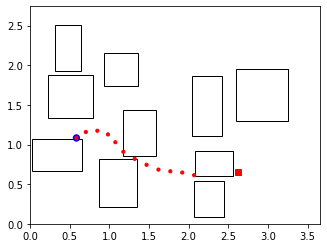

In [10]:
# Xopt = optvals[0]
#
# obstacles = []
# for ii_obs in range(n_obs):
#     obs = prob_params['obstacles'][:,ii_obs]
#     obstacles.append(obs)
#
# if len(obstacles) is n_obs:
#     plt.axes()
#     for obstacle in obstacles:
#         rectangle = plt.Rectangle((obstacle[0], obstacle[2]), \
#                                   obstacle[1]-obstacle[0], obstacle[3]-obstacle[2], \
#                                  fc='white', ec='black')
#         plt.gca().add_patch(rectangle)
#         plt.axis('scaled')
#
#
#     xg = prob_params['xg']
#     x0 = prob_params['x0']
#     circle = plt.Circle((x0[0],x0[1]), 0.04, fc='blue',ec="blue")
#     plt.gca().add_patch(circle)
#
#     #blue line is network prediction
#     plt.plot(xg[0],xg[1],'sr')
#     # plt.quiver(Xopt[0,:], Xopt[1,:], Xopt[2,:], Xopt[3,:])#plot using arrows
#     for jj in range(N):
#         circle = plt.Circle((Xopt[0,jj],Xopt[1,jj]), 0.02, fc='red',ec="red")
#         plt.gca().add_patch(circle)
#
#
#     ax = plt.gca()
#     ax.margins(0)
#     ax.set(xlim=(posmin[0],posmax[0]), ylim=(posmin[1],posmax[1]))
#     plt.show()

In [ ]:
n_test = 2000
framework = 'OMISTL'
n_succ = 0
count = 0
gurobi_fail = 0

costs = []
total_time_ML = []
num_solves = []

cost_ratios = []
costs_ip = []
total_time_ip = []

for ii in tqdm(range(n_test)):
    if ii % 1000 == 0:
        print('{} / {}'.format(ii,n_test))
    prob_params = {}
    for k in p_test.keys():
        prob_params[k] = p_test[k][ii]

    try:
        prob_success, cost, total_time, n_evals, optvals,y_guess = MPC_obj.forward(prob_params, max_evals=10, solver=cp.GUROBI)

        if prob_success:
            n_succ += 1
            costs += [cost]
            total_time_ML += [total_time]
            num_solves += [n_evals]

            true_cost = cost_test[ii]
            costs_ip += [true_cost]
            total_time_ip += [times_test[ii]]

            cost_ratios += [cost / true_cost]
        count += 1
    except (KeyboardInterrupt, SystemExit):
        raise
    except:
        print('Solver failed at {}'.format(ii))
        gurobi_fail += 1
        continue

costs = np.array(costs)
cost_ratios = np.array(cost_ratios)
total_time_ML = np.array(total_time_ML)
num_solves = np.array(num_solves, dtype=int)

costs_ip = np.array(costs_ip)
total_time_ip = np.array(total_time_ip)

percentage = 100 * float(n_succ) / float(count)
dict = {'framework':framework,'N':N,'n_obs':n_obs,'costs':costs, 'total_time_ML':total_time_ML,'num_solves':num_solves, 'costs_ip':costs_ip, 'total_time_ip':total_time_ip, 'cost_ratios':cost_ratios,'strategies':MPC_obj.n_strategies,'percentage':percentage,}
f_save = open(dataset_fn+'/result.pkl', 'wb')
pickle.dump(dict, f_save)
f_save.close()

In [10]:
# load results
N = 8
n_obs = 10
results = load_result(N=N,n_obs=n_obs)
print(results)

{'framework': 'OMISTL', 'costs': array([141.64417486,  26.88436094,  13.89747605, ...,  11.38300457,
        36.19873741,  86.40482951]), 'total_time_ML': array([0.01562309, 0.        , 0.        , ..., 0.03125191, 0.        ,
       0.01562691]), 'num_solves': array([1, 1, 1, ..., 5, 1, 1]), 'costs_ip': array([141.64424827,  26.88445664,  13.89748213, ...,  11.50938872,
        36.19862202,  87.27345367]), 'total_time_ip': array([0.10700226, 0.22599792, 0.08699608, ..., 0.33400345, 0.20100021,
       0.53097534]), 'cost_ratios': array([0.99999948, 0.99999644, 0.99999956, ..., 0.98901904, 1.00000319,
       0.9900471 ]), 'percentage': 92.90853031860226}


## test results

In [ ]:
for i in range(5,11):
    test_strategy(10,i)

## load results

In [112]:
N = 8
n_obs = 10
test_strategy(N,n_obs)
results = load_result(N=N,n_obs=n_obs)
print(results)

nubmber of strategies:983
n_obs: 10
N: 8
Loading presaved classifier model from D:\Curious\OMISTL\models\MPC_horizon_8_obs_10.pt


  0%|          | 0/400 [00:00<?, ?it/s]

0 / 400


 10%|█         | 40/400 [00:04<00:40,  8.96it/s]D:\Curious\OMISTL\MPC\test_results.py:151: RuntimeWarning: divide by zero encountered in double_scalars
  cost_ratios += [cost / true_cost]
100%|██████████| 400/400 [00:47<00:00,  8.37it/s]


{'framework': 'OMISTL', 'N': 8, 'n_obs': 10, 'costs': array([141.64442018,  26.88449467,  13.93885186,  46.78793655,
        12.25665451,  11.23002882, 139.03191223,  18.07905173,
         7.44513687,  32.38252204,  31.92416317, 119.50552848,
        49.80212125,  38.75261684,  12.67942196,  74.40904183,
       182.63635626,  16.29953153,  21.13723826,  75.43351822,
         0.23010067, 135.74781941,  28.84837085,   0.53481933,
       124.48478887,  60.94744965,   2.730527  ,   0.59833686,
        25.0226615 ,   0.71523936,  25.18142728, 183.24370146,
         5.71966028,  38.24558756,  45.44856601,  77.81518523,
        33.12888089,  47.75725202,   1.8876952 ,  83.83234515,
        21.92838841,  23.50202034,  16.32376313,   1.11274229,
        30.02099011, 107.84987127,  71.57196249,  25.8845697 ,
        10.61862588,  49.68459529,  30.86404869,  10.80044839,
        14.00631559,  79.91761299,  57.62274463,   0.40072968,
         7.27641024,   7.64083252,  14.49020848,  97.49568855,
 

In [102]:
from test_results import load_result
N=12
plot_horizons = [10,12]
percent_successes = []
for ii, N in enumerate(plot_horizons):
    percent_successes_eachN = []
    for idx_obs in range(5,11):
        n_obs=idx_obs
        results = load_result(N=N,n_obs=n_obs)
        print('N: '+ str(N) + ' obs: '+ str(n_obs)+' success percentege: '+ str(results['percentage']) + ' number of strategies: '+ str(results['strategies']))
        percent_successes_eachN.append(results['percentage'])
    percent_successes.append(percent_successes_eachN)
print(percent_successes)
percent_successes[0][-1]=84.421

N: 10 obs: 5 success percentege: 90.76923076923077 number of strategies: 2202
N: 10 obs: 6 success percentege: 86.85567010309278 number of strategies: 2173
N: 10 obs: 7 success percentege: 87.30569948186529 number of strategies: 2437
N: 10 obs: 8 success percentege: 82.68733850129199 number of strategies: 2615
N: 10 obs: 9 success percentege: 81.25 number of strategies: 2617
N: 10 obs: 10 success percentege: 90.55118110236221 number of strategies: 2871
N: 12 obs: 5 success percentege: 87.59689922480621 number of strategies: 4580
N: 12 obs: 6 success percentege: 85.8288770053476 number of strategies: 4336
N: 12 obs: 7 success percentege: 82.47422680412372 number of strategies: 4287
N: 12 obs: 8 success percentege: 72.63157894736842 number of strategies: 4958
N: 12 obs: 9 success percentege: 77.4869109947644 number of strategies: 5991
N: 12 obs: 10 success percentege: 76.5625 number of strategies: 6201
[[90.76923076923077, 86.85567010309278, 87.30569948186529, 82.68733850129199, 81.25, 9

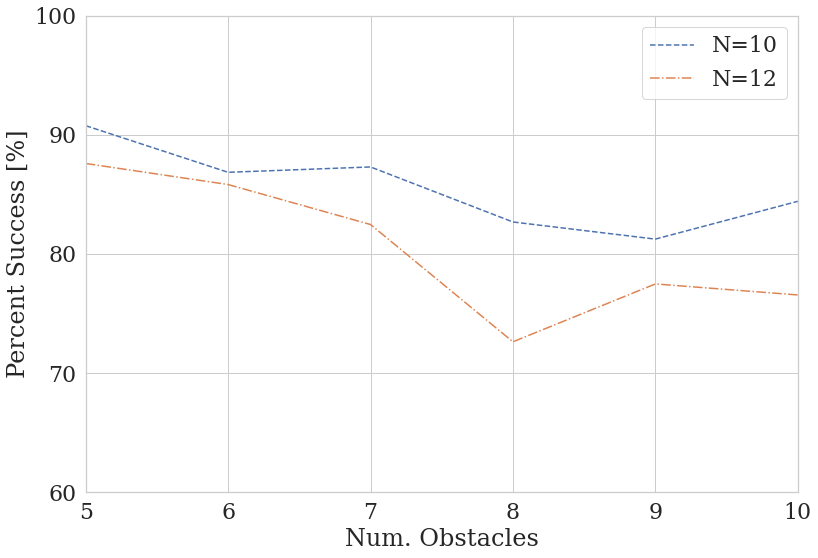

In [111]:
sns.set(font_scale=2, font="serif", style="whitegrid")

flierprops = {'alpha':0.5}
# sns.set(rc={'figure.figsize':(11.7,8.27)})

linestyles = ['--', '-.', '-', ':']

for ii, N in enumerate(plot_horizons):
    batch_percent_success = percent_successes[ii]
    xlabels = [ii for ii in range(0,6)]
    x_labels = [ii for ii in range(5,11)]
    y_labels = [batch_percent_success[x] for x in xlabels]
    ax1 = sns.lineplot(x=x_labels, y=y_labels, palette="Set3", label='N={}'.format(N), linewidth=1.5)
    ax1.lines[ii].set_linestyle(linestyles[ii])
    # ax1.set(xlabel="", ylabel="Percent Success")

ax1.set(xlabel="Num. Obstacles", ylabel="Percent Success [%]")
# ax1.grid(False)
#
yticks =  [10*ii for ii in range(11)]
ax1.set_yticks(yticks)

#
plt.tight_layout()
plt.legend(loc='upper right')
plt.xlim([5,10])
# plt.xticks(fontsize=13)
plt.ylim([60.,100.])
# plt.yticks(fontsize=13)


# sns.set_style("whitegrid")
st = sns.axes_style("whitegrid")
# sns.set_color_codes("")

figure = ax1.get_figure()
my_path ='G:\destop\project\SYCAMORE_report_template/figure'
figure.savefig(my_path+"/percent_success_mpc.png")